In [1]:
%load_ext zipline


In [2]:
%zipline ingest --help

from zipline.data import bundles
import os
import pandas as pd
from zipline.data.bundles import register, load
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.data.bundles.yahoo import yahoo_stock_data
from zipline.data.data_portal import DataPortal
from zipline import run_algorithm
from zipline.api import schedule_function
from zipline.pipeline.data import Column
from zipline.pipeline.pipeline import Pipeline

from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.loaders import USEquityPricingLoader
from trading_calendars.trading_calendar import TradingCalendar
from trading_calendars import get_calendar
import itertools
from zipline.pipeline.filters import StaticAssets

# Import visualization
import matplotlib.pyplot as plt

Usage: %zipline [OPTIONS]

  Run a backtest for the given algorithm.

Options:
  -f, --algofile FILENAME         The file that contains the algorithm to run.
  -t, --algotext TEXT             The algorithm script to run.
  -D, --define TEXT               Define a name to be bound in the namespace
                                  before executing the algotext. For example
                                  '-Dname=value'. The value may be any python
                                  expression. These are evaluated in order so
                                  they may refer to previously defined names.
  --data-frequency [minute|daily]
                                  The data frequency of the simulation.
                                  [default: daily]
  --capital-base FLOAT            The starting capital for the simulation.
                                  [default: 10000000.0]
  -b, --bundle BUNDLE-NAME        The data bundle to use for the simulation.
                          

In [3]:
# result = run_algorithm(
#     start=start_session, 
#     end=end_session, 
#     initialize=initialize, 
#     analyze=analyze, 
#     handle_data=handle_data, 
#     capital_base=100000, 
#     data_frequency = 'daily', 
#     bundle='yahoo-bundle',
   
# ) 


In [4]:
import pandas as pd
perf = pd.read_pickle('nse_20162019_weekly.pickle') # read in perf DataFrame

In [5]:
# Import visualization
import matplotlib.pyplot as plt
def analyze(perf):
    fig = plt.figure(figsize=(12, 8))
    
    # First chart
    ax = fig.add_subplot(311)
    ax.set_title('Strategy Results')
    ax.semilogy(perf['portfolio_value'], linestyle='-', 
                label='Equity Curve', linewidth=3.0)
    ax.legend()
    ax.grid(False)
    
    # Second chart
    ax = fig.add_subplot(312)
    ax.plot(perf['gross_leverage'], 
            label='Exposure', linestyle='-', linewidth=1.0)
    ax.legend()
    ax.grid(True)

    # Third chart
    ax = fig.add_subplot(313)
    ax.plot(perf['returns'], label='Returns', linestyle='-.', linewidth=1.0)
    ax.legend()
    ax.grid(True)  

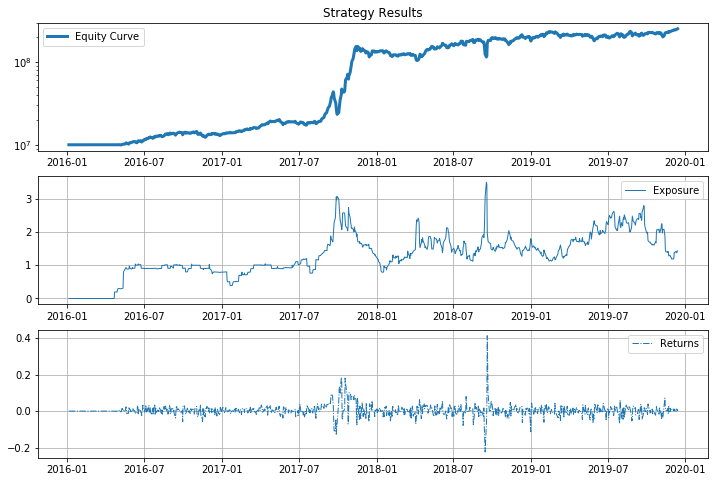

In [6]:
analyze(perf)

In [7]:
perf.to_csv("results.csv")

In [8]:
import pandas as pd
import pyfolio as pf

In [9]:
results = pd.read_pickle('nse_20162019_weekly.pickle')
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Text(0.5, 0, 'Date')

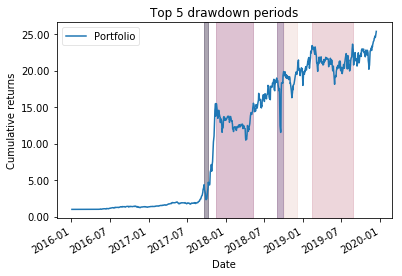

In [10]:
pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')

Start date,2016-01-04
End date,2019-12-13
Total months,46
,Backtest
Annual return,131.9%
Cumulative returns,2437.5%
Annual volatility,50.3%
Sharpe ratio,1.92
Calmar ratio,2.82
Stability,0.88
Max drawdown,-46.7%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,46.74,2017-09-20,2017-09-29,2017-10-10,15
1,39.22,2018-08-29,2018-09-17,2018-09-28,23
2,32.34,2017-11-13,2018-04-05,2018-05-11,130
3,22.62,2019-02-12,2019-05-30,2019-08-23,139
4,18.01,2018-10-01,2018-11-09,2018-12-05,48


Stress Events,mean,min,max
New Normal,0.38%,-22.43%,41.37%


Top 10 long positions of all time,max
sid,
KIOCL.NS,198.87%
TIMKEN.NS,26.72%
NESCO.NS,17.17%
MAHLOG.NS,16.82%
HSCL.NS,16.76%
ICRA.NS,16.40%
INFIBEAM.NS,16.13%
SUVEN.NS,15.41%
WELCORP.NS,15.32%


Top 10 short positions of all time,max
sid,
KIOCL.NS,-230.61%
TIMKEN.NS,-38.42%
ESSELPACK.NS,-28.96%
KNRCON.NS,-20.75%
MAHABANK.NS,-10.41%
ORIENTELEC.NS,-9.64%
MAHSCOOTER.NS,-9.28%
IBULISL.NS,-8.81%
ZYDUSWELL.NS,-8.57%


Top 10 positions of all time,max
sid,
KIOCL.NS,230.61%
TIMKEN.NS,38.42%
ESSELPACK.NS,28.96%
KNRCON.NS,20.75%
NESCO.NS,17.17%
MAHLOG.NS,16.82%
HSCL.NS,16.76%
ICRA.NS,16.40%
INFIBEAM.NS,16.13%


/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/pyfolio/round_trips.py:80: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/pyfolio/round_trips.py:83: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/pyfolio/round_trips.py:86: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/pyfolio/round_trips.py:90: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/pyfolio/round_trips.py:379: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,1720.00,255.00,1465.00
Percent profitable,0.54,0.60,0.53
Winning round_trips,926.00,152.00,774.00
Losing round_trips,794.00,103.00,691.00
Even round_trips,0.00,0.00,0.00


PnL stats,All trades,Short trades,Long trades
Total profit,$243816340.15,$170232381.06,$73583959.09
Gross profit,$425996888.76,$187365005.54,$238631883.23
Gross loss,$-182180548.61,$-17132624.48,$-165047924.14
Profit factor,$2.34,$10.94,$1.45
Avg. trade net profit,$141753.69,$667577.96,$50227.96
Avg. winning trade,$460039.84,$1232664.51,$308309.93
Avg. losing trade,$-229446.53,$-166336.16,$-238853.73
Ratio Avg. Win:Avg. Loss,$2.00,$7.41,$1.29
Largest winning trade,$167402788.01,$167402788.01,$18803725.34
Largest losing trade,$-6620176.35,$-1241528.44,$-6620176.35


Duration stats,All trades,Short trades,Long trades
Avg duration,30 days 20:42:12.559883,33 days 05:33:10.588235,30 days 10:48:29.490102
Median duration,21 days 00:00:00,20 days 00:00:00,21 days 00:00:00
Longest duration,682 days 14:00:01,682 days 14:00:01,196 days 00:00:00
Shortest duration,0 days 09:59:59,0 days 09:59:59,0 days 09:59:59


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.11%,0.27%,0.08%
Avg returns winning,0.37%,0.50%,0.35%
Avg returns losing,-0.20%,-0.08%,-0.22%
Median returns all round_trips,0.00%,0.01%,0.00%
Median returns winning,0.06%,0.04%,0.08%
Median returns losing,-0.06%,-0.04%,-0.07%
Largest winning trade,66.53%,66.53%,12.14%
Largest losing trade,-3.28%,-0.56%,-3.28%


Symbol stats,COX&KINGS.NS,BAJAJFINSV.NS,TIMKEN.NS,KEI.NS,UFLEX.NS,LALPATHLAB.NS,UJJIVAN.NS,BBTC.NS,JKPAPER.NS,MANAPPURAM.NS,LUPIN.NS,GNFC.NS,VGUARD.NS,MOTILALOFS.NS,INFIBEAM.NS,LAKSHVILAS.NS,TATAELXSI.NS,RELAXO.NS,JYOTHYLAB.NS,IRB.NS,SUZLON.NS,ZENSARTECH.NS,FORTIS.NS,SHILPAMED.NS,GEPIL.NS,PEL.NS,REPCOHOME.NS,FDC.NS,LTTS.NS,NCC.NS,TATAGLOBAL.NS,BEML.NS,BALRAMCHIN.NS,AUBANK.NS,LUXIND.NS,COLPAL.NS,PHOENIXLTD.NS,VAKRANGEE.NS,SWANENERGY.NS,SUVEN.NS,JMFINANCIL.NS,RENUKA.NS,BLUESTARCO.NS,COROMANDEL.NS,KOLTEPATIL.NS,GALAXYSURF.NS,NBCC.NS,BIRLACORPN.NS,TATAMTRDVR.NS,HDFCAMC.NS,ALBK.NS,KIRLOSENG.NS,HEXAWARE.NS,FCONSUMER.NS,TEAMLEASE.NS,MAHSEAMLES.NS,GHCL.NS,JPASSOCIAT.NS,TRENT.NS,PNBHOUSING.NS,MINDTREE.NS,GRAPHITE.NS,REDINGTON.NS,AEGISCHEM.NS,ABB.NS,MINDAIND.NS,SONATSOFTW.NS,JUBILANT.NS,JKTYRE.NS,ESCORTS.NS,HSCL.NS,ORIENTCEM.NS,FINCABLES.NS,IDBI.NS,FLFL.NS,BEL.NS,MAHLOG.NS,RCOM.NS,KEC.NS,PNB.NS,RPOWER.NS,RCF.NS,SHARDACROP.NS,RADICO.NS,ITDC.NS,HFCL.NS,TATAMOTORS.NS,MOIL.NS,HINDALCO.NS,ASTRAZEN.NS,ADVENZYMES.NS,SREINFRA.NS,BAJAJELEC.NS,TV18BRDCST.NS,MAHABANK.NS,NMDC.NS,JINDALSTEL.NS,DCMSHRIRAM.NS,TAKE.NS,BANKINDIA.NS,JSLHISAR.NS,3MINDIA.NS,ENGINERSIN.NS,DEEPAKFERT.NS,WOCKPHARMA.NS,NH.NS,NIACL.NS,BIOCON.NS,APOLLOHOSP.NS,NFL.NS,CYIENT.NS,ITI.NS,AVANTIFEED.NS,MFSL.NS,DCBBANK.NS,VEDL.NS,GICRE.NS,IPCALAB.NS,CENTRALBK.NS,BALMLAWRIE.NS,DLF.NS,CEATLTD.NS,DMART.NS,BPCL.NS,JAICORPLTD.NS,DCAL.NS,KSCL.NS,HEG.NS,RAJESHEXPO.NS,ESSELPACK.NS,GSFC.NS,KIOCL.NS,ADANIGREEN.NS,NAVINFLUOR.NS,QUESS.NS,COFFEEDAY.NS,SIS.NS,INDIANB.NS,RUPA.NS,MUTHOOTFIN.NS,J&KBANK.NS,ELGIEQUIP.NS,M&MFIN.NS,WHIRLPOOL.NS,JUBLFOOD.NS,GRANULES.NS,TORNTPOWER.NS,GODREJPROP.NS,TITAN.NS,TVTODAY.NS,SRF.NS,SUNTECK.NS,YESBANK.NS,CAPLIPOINT.NS,BANDHANBNK.NS,FRETAIL.NS,EDELWEISS.NS,IFBIND.NS,SAIL.NS,CUB.NS,MPHASIS.NS,BAJFINANCE.NS,DIXON.NS,GODREJCP.NS,PHILIPCARB.NS,DEEPAKNTR.NS,IBREALEST.NS,JSL.NS,SIEMENS.NS,VIPIND.NS,ICRA.NS,CREDITACC.NS,NAUKRI.NS,IDEA.NS,JUSTDIAL.NS,LTI.NS,TCS.NS,IOC.NS,RNAM.NS,PAGEIND.NS,DBL.NS,IBULISL.NS,TIMETECHNO.NS,MRF.NS,INDIACEM.NS,JETAIRWAYS.NS,GMDCLTD.NS,KRBL.NS,VINATIORGA.NS,JINDALSAW.NS,HEIDELBERG.NS,SHK.NS,ASHOKLEY.NS,EXCELCROP.NS,CIPLA.NS,WELCORP.NS,DIVISLAB.NS,HERITGFOOD.NS,ABFRL.NS,NESCO.NS,VMART.NS,HINDCOPPER.NS,MAHSCOOTER.NS,PCJEWELLER.NS,NBVENTURES.NS,PNCINFRA.NS,ADANITRANS.NS,PRAJIND.NS,STRTECH.NS,CANFINHOME.NS,SUDARSCHEM.NS,SUPRAJIT.NS,GUJALKALI.NS,JAMNAAUTO.NS,HATHWAY.NS,UPL.NS,INTELLECT.NS,ERIS.NS,KARURVYSYA.NS,MHRIL.NS,BAJAJHLDNG.NS,FSL.NS,TNPL.NS,RAYMOND.NS,RECLTD.NS,ORIENTBANK.NS,NIITTECH.NS,STARCEMENT.NS,ORIENTELEC.NS,MINDACORP.NS,BERGEPAINT.NS,AUROPHARMA.NS,BASF.NS,EIHOTEL.NS,SUNDRMFAST.NS,ADANIPOWER.NS,CHAMBLFERT.NS,SHANKARA.NS,HINDPETRO.NS,SOBHA.NS,TRIDENT.NS,PFC.NS,BRIGADE.NS,RAIN.NS,VENKEYS.NS,VBL.NS,TECHM.NS,KNRCON.NS,PARAGMILK.NS,CHENNPETRO.NS,GRUH.NS,AAVAS.NS,SBILIFE.NS,PFIZER.NS,SCI.NS,BATAINDIA.NS,JBCHEPHARM.NS,MONSANTO.NS,DELTACORP.NS,MGL.NS,BOMDYEING.NS,PRESTIGE.NS,ZYDUSWELL.NS,FINEORG.NS,POWERGRID.NS,NATIONALUM.NS,IBVENTURES.NS
Avg returns all round_trips,-0.35%,0.18%,-0.07%,0.02%,0.34%,-1.06%,-0.05%,0.11%,0.20%,0.73%,-0.80%,0.00%,0.32%,0.15%,0.18%,0.31%,0.21%,-0.26%,0.96%,-0.08%,-0.01%,-0.12%,-0.46%,-0.01%,-0.11%,0.18%,-0.25%,-0.08%,-0.77%,-0.74%,0.05%,-0.20%,-0.22%,0.14%,0.25%,-0.25%,-0.35%,-0.27%,0.63%,-0.22%,-0.20%,0.16%,0.03%,0.16%,0.32%,0.09%,-0.13%,-0.05%,-1.08%,0.37%,-0.16%,-0.02%,0.11%,-0.38%,-0.92%,0.04%,-0.39%,0.21%,0.37%,-0.09%,-0.04%,0.21%,-0.02%,-0.19%,-0.20%,-0.37%,0.25%,-0.05%,0.39%,0.25%,0.59%,0.00%,-0.18%,-0.52%,0.13%,0.34%,0.10%,-0.26%,-0.42%,0.23%,-1.47%,0.02%,0.25%,-0.08%,-0.56%,-0.25%,-1.70%,0.00%,0.32%,0.06%,-1.19%,-0.51%,0.10%,0.23%,0.05%,0.09%,0.01%,0.05%,-0.40%,-0.60%,0.43%,-0.03%,0.05%,-0.47%,-0.13%,-0.01%,-0.05%,0.01%,0.10%,0.73%,-0.40%,0.24%,-0.01%,-0.49%,0.14%,0.13%,-0.19%,0.60%,-0.13%,-0.18%,-0.67%,-0.10%,0.92%,-0.01%,-0.35%,-0.27%,0.57%,0.36%,-0.13%,0.05%,-0.28%,2.20%,0.23%,0.21%,0.46%,0.27%,-0.02%,-0.05%,-0.86%,-0.40%,-0.15%,0.09%,-0.17%,0.07%,0.32%,0.15%,-0.22%,-0.53%,-0.23%,-0.01%,-0.09%,0.17%,-0.20%,-

Profitability (PnL / PnL total) per name,
symbol,
KIOCL.NS,106.28%
ADANIGREEN.NS,4.16%
MAHABANK.NS,3.49%
IBVENTURES.NS,2.61%
HEG.NS,2.41%
ESSELPACK.NS,2.23%
RAIN.NS,2.07%
IBULISL.NS,2.00%
FINEORG.NS,1.42%


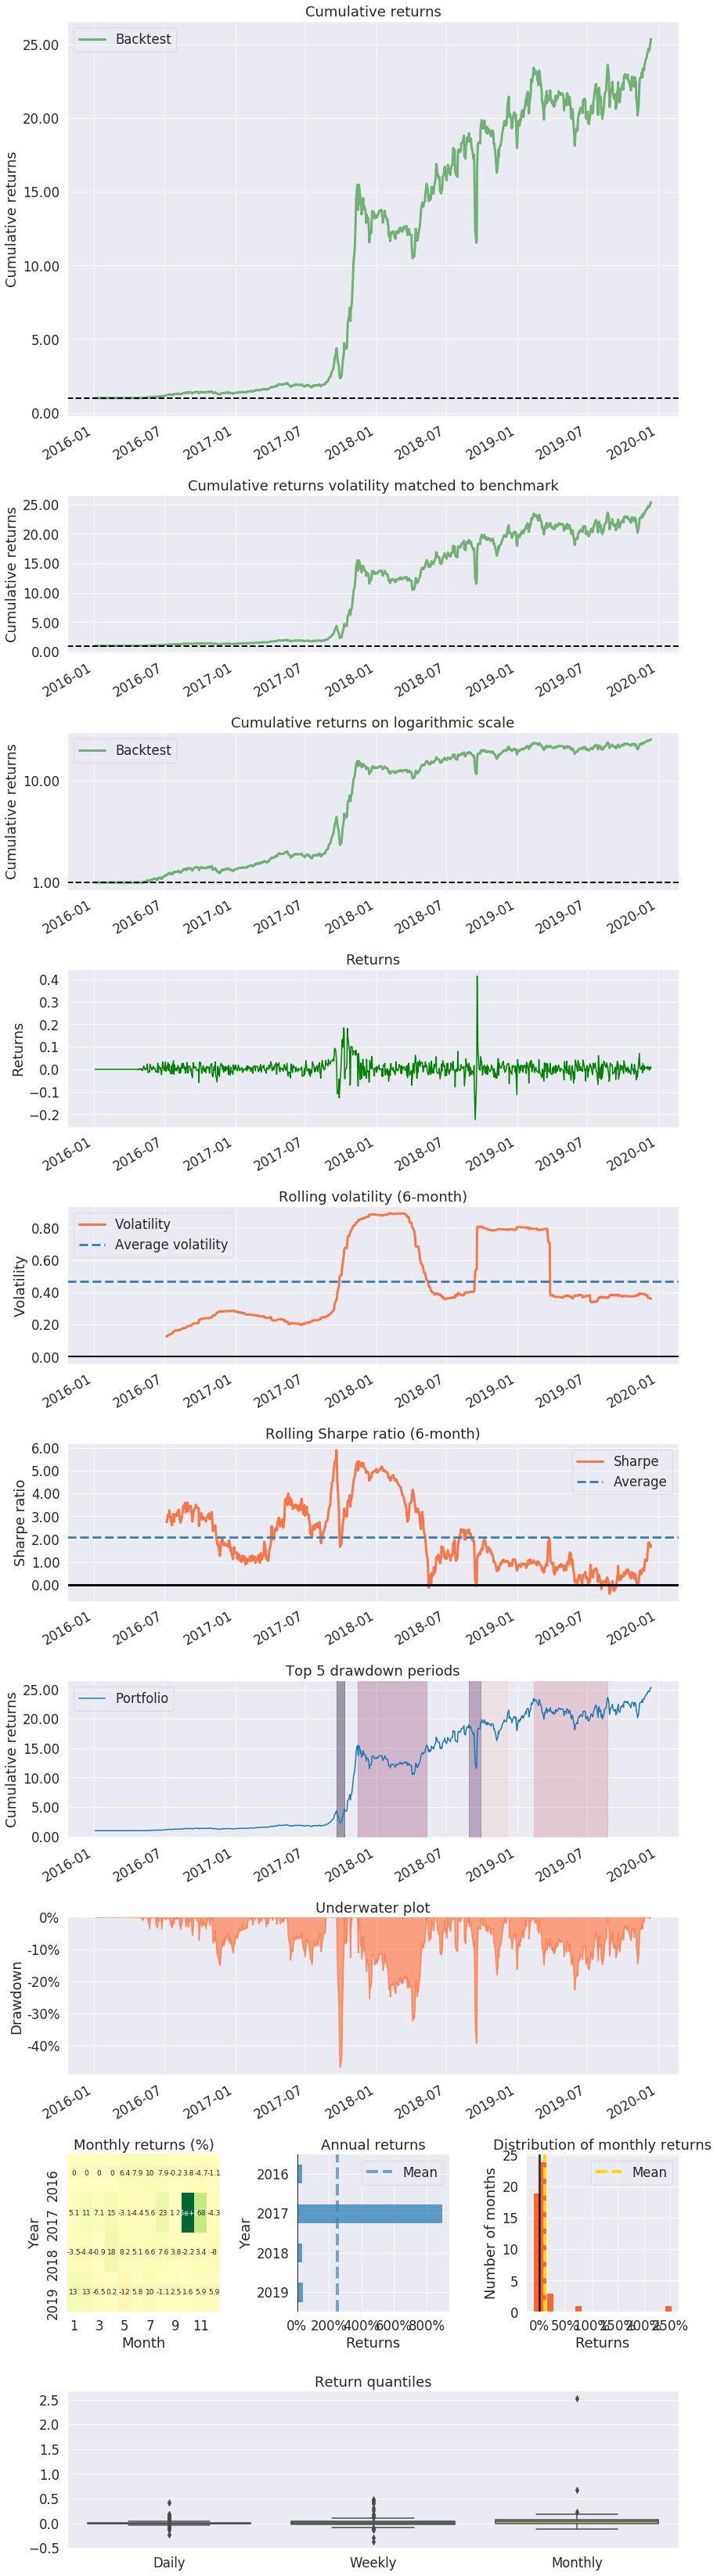

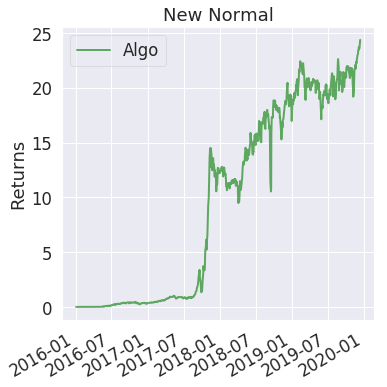

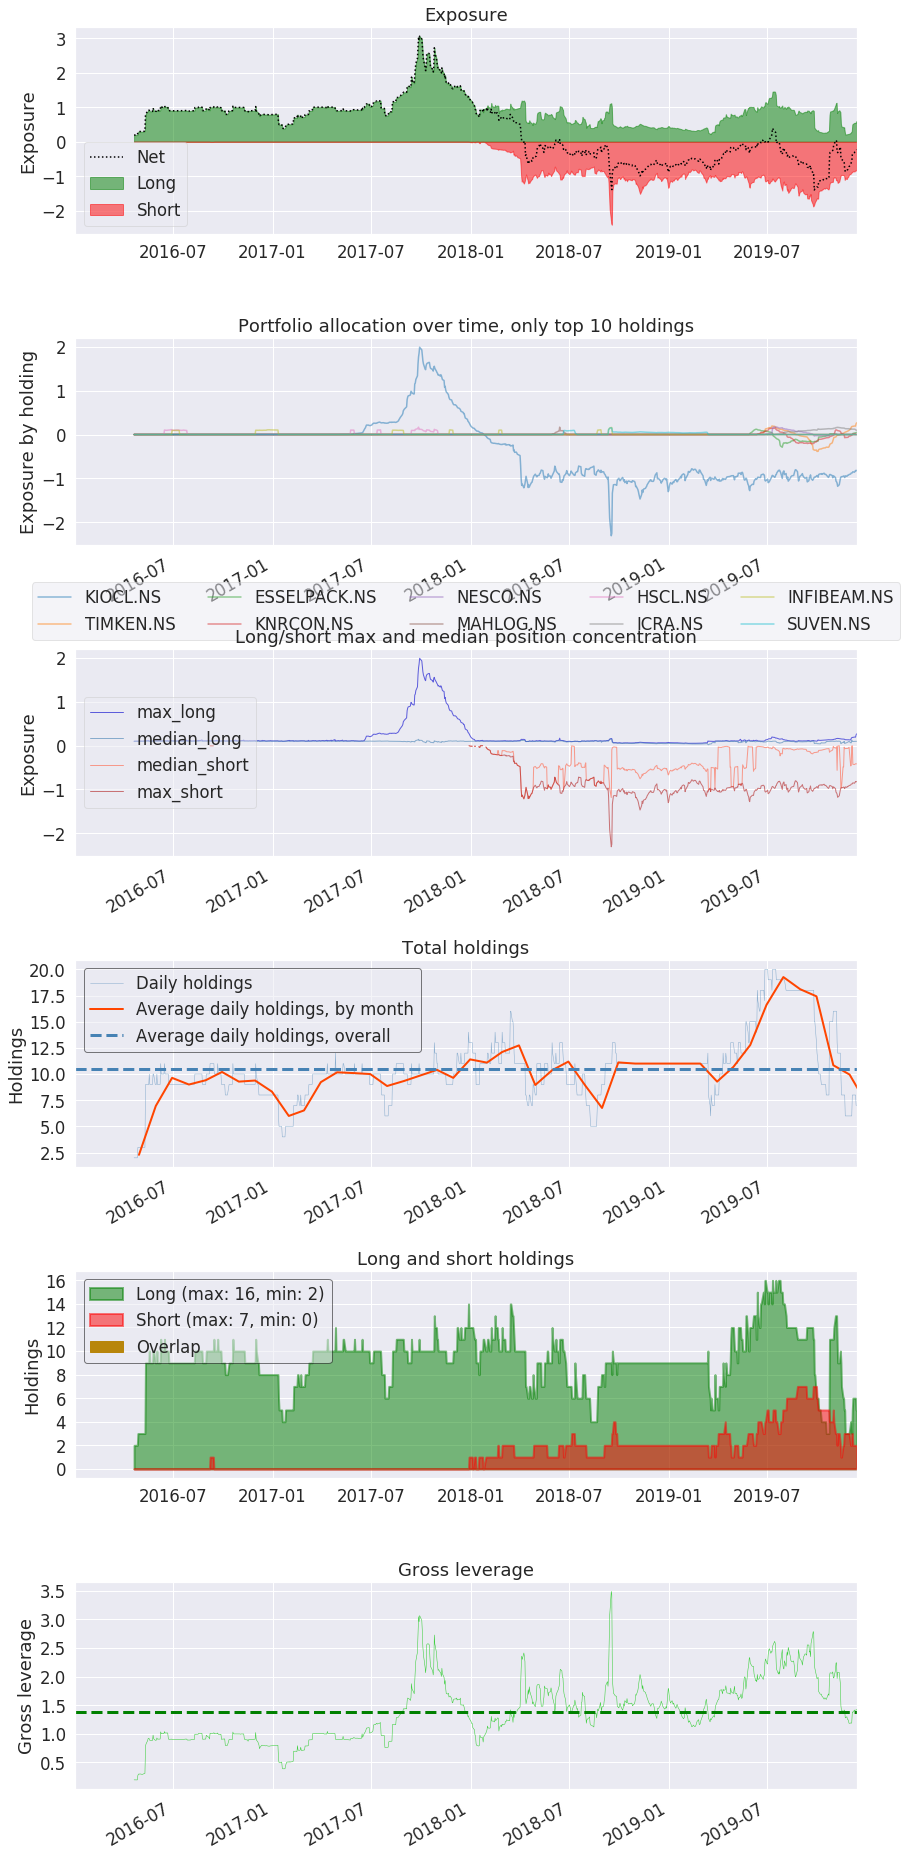

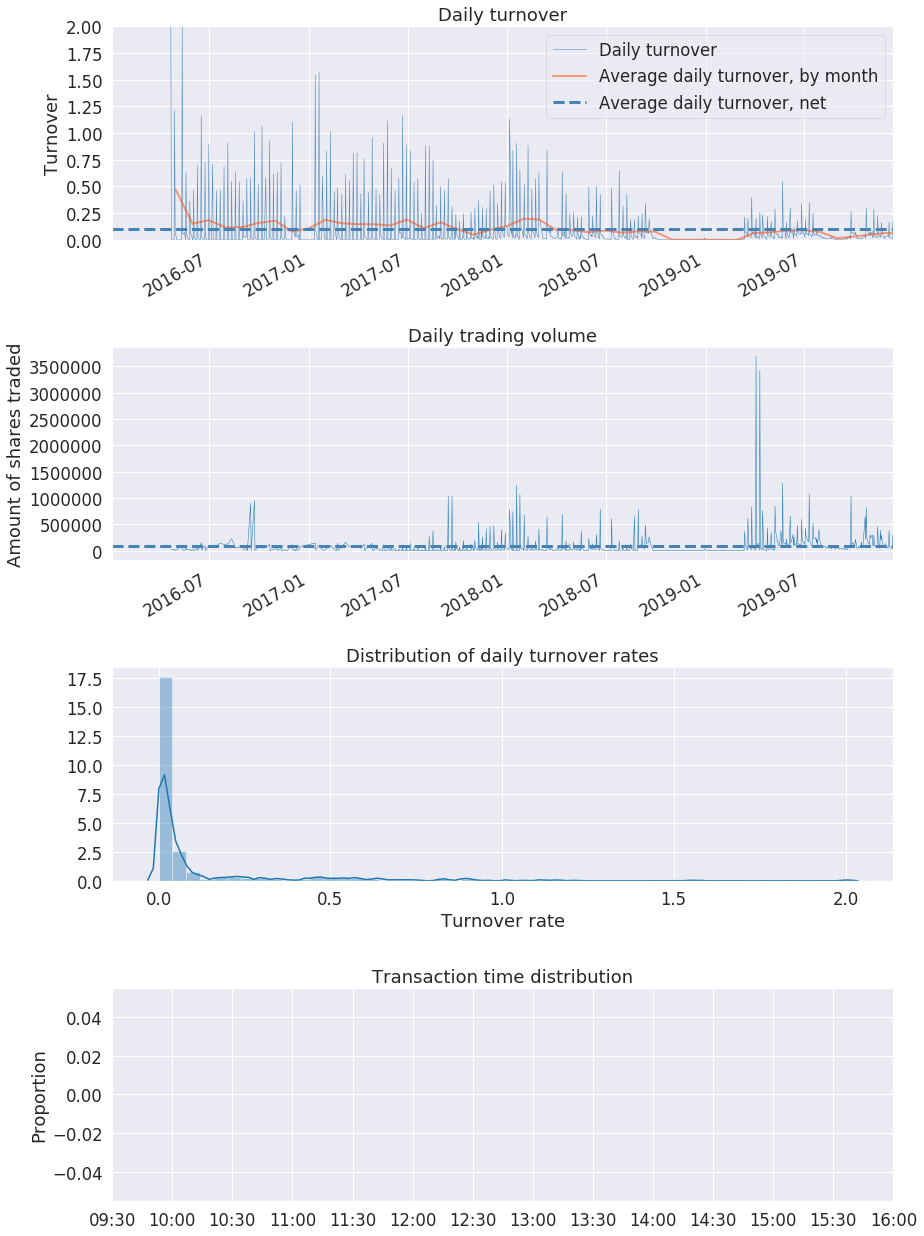

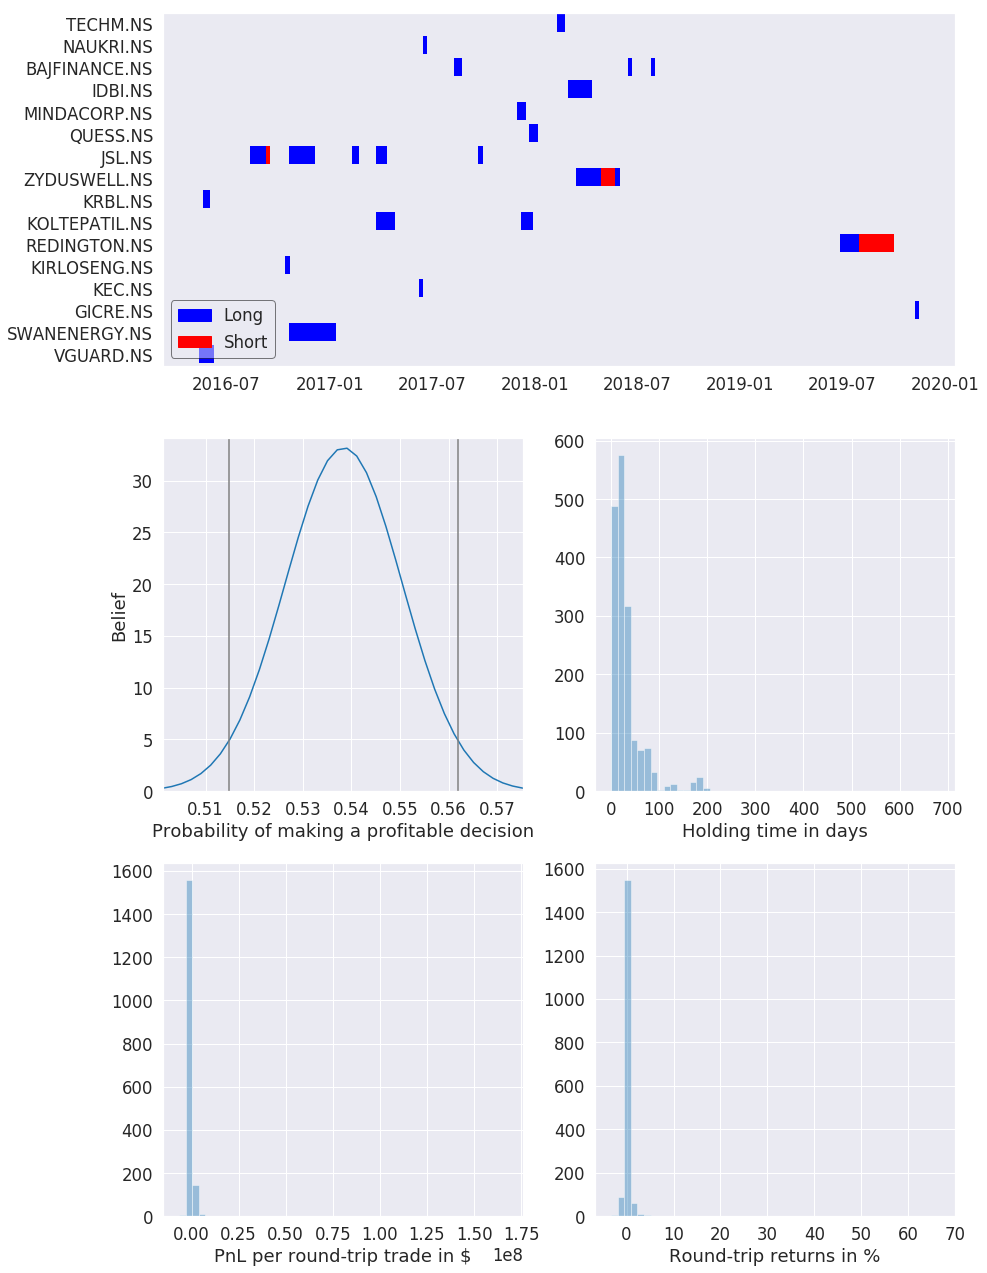

In [11]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, round_trips=True)

/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['eurostile'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


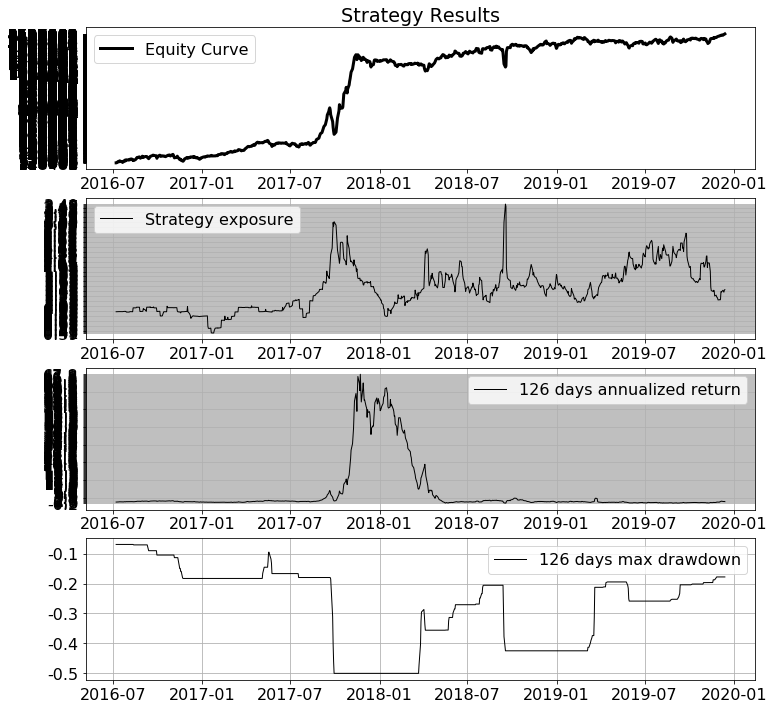

In [12]:
# Custom Time Series Analysis

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt, rc, ticker

# Format for book image
font = {'family' : 'eurostile',
        'weight' : 'normal',
        'size'   : 16}
rc('font', **font)

# Settings
calc_window = 126
year_length = 252

# Copy the columns we need
df = perf.copy().filter(items=['portfolio_value', 'gross_leverage'])

# Function for annualized return
def ann_ret(ts):
    return np.power((ts[-1] / ts[0]), (year_length/len(ts))) -1  

# Function for drawdown
def dd(ts):
    return np.min(ts / np.maximum.accumulate(ts)) - 1

# Get a rolling window
rolling_window = perf.portfolio_value.rolling(calc_window)

# Calculate rolling analytics
df['annualized'] = rolling_window.apply(ann_ret)
df['drawdown'] = rolling_window.apply(dd)

# Drop initial n/a values
df.dropna(inplace=True)

# Make a figure
fig = plt.figure(figsize=(12, 12))

# Make the base lower, just to make the graph easier to read
df['portfolio_value'] /= 100

# First chart
ax = fig.add_subplot(411)
ax.set_title('Strategy Results')
ax.plot(df['portfolio_value'], 
        linestyle='-', 
        color='black',
        label='Equity Curve', linewidth=3.0)

# Set log scale
ax.set_yscale('log') 

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['portfolio_value'].min(), df['portfolio_value'].max(), 500 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

# Add legend and grid
ax.legend()
ax.grid(False)

# Second chart
ax = fig.add_subplot(412)
ax.plot(df['gross_leverage'], 
        label='Strategy exposure'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['gross_leverage'].min(), df['gross_leverage'].max(), 0.02 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Third chart
ax = fig.add_subplot(413)
ax.plot(df['annualized'], 
        label='{} days annualized return'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['annualized'].min(), df['annualized'].max(), 0.5 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Fourth chart
ax = fig.add_subplot(414)
ax.plot(df['drawdown'], 
        label='{} days max drawdown'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['drawdown'].min(), df['drawdown'].max(), 0.1 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

# Add legend and grid
ax.legend()
ax.grid(True)


In [13]:
df

,portfolio_value,gross_leverage,annualized,drawdown
2016-07-07 10:00:00+00:00,1.184820e+05,0.900041,0.403799,-0.036962
2016-07-08 10:00:00+00:00,1.185474e+05,0.900096,0.405348,-0.036962
2016-07-11 10:00:00+00:00,1.221395e+05,0.903034,0.491806,-0.036962
2016-07-12 10:00:00+00:00,1.214512e+05,0.902485,0.475040,-0.036962
2016-07-13 10:00:00+00:00,1.215465e+05,0.902561,0.477355,-0.036962
2016-07-14 10:00:00+00:00,1.243527e+05,0.903144,0.546358,-0.036962
2016-07-15 10:00:00+00:00,1.237633e+05,0.902683,0.531736,-0.036962
2016-07-18 10:00:00+00:00,1.212941e+05,0.900702,0.471225,-0.036962
2016-07-19 10:00:00+00:00,1.208092e+05,0.900303,0.459486,-0.036962
2016-07-20 10:00:00+00:00,1.227031e+05,0.901842,0.505606,-0.036962
